<a href="https://colab.research.google.com/github/Bigulac/MOAR/blob/main/MOAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Следећи код представља конволутивну неуралну мрежу која је истренирана да разликује слике паса и мачака.

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

# Skida dataset sa interneta
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip


# Izbacuje slike koje su oštećene ili nečitljive proverom da li ima JFIF tag u zapisu
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Brisanje slika
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

# Definisanje dimenzija slika i veličine
image_size = (180, 180)
batch_size = 128

# Pravi skup slika za treninranje modela i validaciju
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Prikaz slika iz dataseta
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title("Pas" if int(labels[i]) else "Mačka")
        plt.axis("off")

# Povećanje skupa malim modifikacijama postojećih slika
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Prikaz kako izgledaju slike nakon modifikacija
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# Primena gornje funkcije na trening skup
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Priprema resursa za treniranje na GPU
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Funkcija za pravljenje modela
def make_model(input_shape, num_classes):

    # Ovde slika ulazi u model
    inputs = keras.Input(shape=input_shape)

    # Ulazni sloj
    x = layers.Rescaling(1.0 / 255)(inputs) # normalizacija slike
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) # Aktivaciona funkcija za unošenje nelinearnosti

    previous_block_activation = x  # Rezultat prvog sloja, potreban za residualne slojeve

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Aktivacija residualnih slojeva
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x  # Sledeći residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    # Izlazni sloj
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs)

# Kreiranje modela
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Treniranje modela
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


plt.plot(history.history['accuracy'])
plt.title('Preciznost modela')
plt.ylabel('preciznost[%]')
plt.xlabel('epoha')
plt.legend(['training'], loc='best')
plt.show()

img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  81.2M      0  0:00:09  0:00:09 --:--:-- 66.6M
Deleted 1590 images.
Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Epoch 1/3


**Код разбијен на мање целине**

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

# Skida dataset sa interneta
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip


# Izbacuje slike koje su oštećene ili nečitljive proverom da li ima JFIF tag u zapisu
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Brisanje slika
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   120M      0  0:00:06  0:00:06 --:--:-- 92.2M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Deleted 1590 images.


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


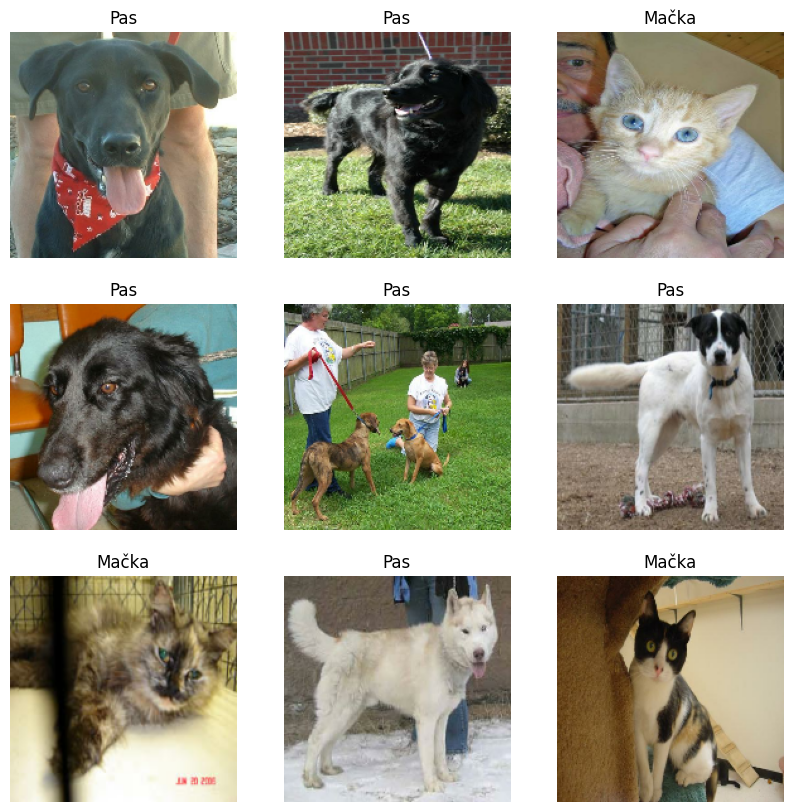

In [ ]:
# Definisanje dimenzija slika i veličine
image_size = (180, 180)
batch_size = 128

# Pravi skup slika za treninranje modela i validaciju
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Prikaz slika iz dataseta
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title("Pas" if int(labels[i]) else "Mačka")
        plt.axis("off")

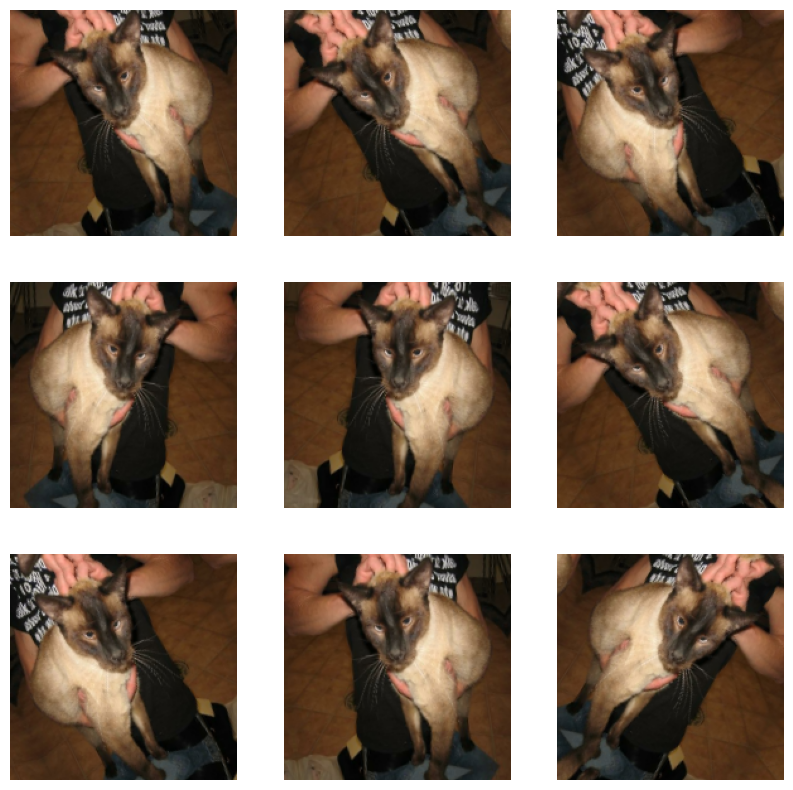

In [ ]:
# Povećanje skupa malim modifikacijama postojećih slika
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Prikaz kako izgledaju slike nakon modifikacija
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# Primena gornje funkcije na trening skup
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)


**Model**

In [ ]:
# Priprema resursa za treniranje na GPU
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Funkcija za pravljenje modela
def make_model(input_shape, num_classes):

    # Ovde slika ulazi u model
    inputs = keras.Input(shape=input_shape)

    # Ulazni sloj
    x = layers.Rescaling(1.0 / 255)(inputs) # normalizacija slike
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) # Aktivaciona funkcija za unošenje nelinearnosti

    previous_block_activation = x  # Rezultat prvog sloja, potreban za residualne slojeve

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Aktivacija residualnih slojeva
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x  # Sledeći residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    # Izlazni sloj
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

# Kreiranje modela
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Treniranje modela i rezultati

In [ ]:

# Treniranje modela
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Čuvanje napretka radi iscrtavanja grafika
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

# Crtanje grafika preciznosti naspram borja epoha
plt.plot(history.history['accuracy'])
plt.title('Preciznost modela')
plt.ylabel('preciznost[%]')
plt.xlabel('epoha')
plt.legend(['training'], loc='best')
plt.show()


# Primer predviđanja
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

NameError: name 'keras' is not defined